# TP Final grupo 5

### Contexto:
#### El dataset tiene informacion de aplicaciones para Android que se disponibilizaron en la appstore de google. La variable objetivo esta definida como un feature binario, que corresponde 1 = app maligna | 0 = app benigna
#### El objetivo es poder identificar algun patron que nos permita identificar si una app es potencialmente maligna o no.
#### Nuestro interes es detectar la mayor cantidad de apps maliciosas (true positive) aun a costa de clasif incorrectamente alguna que no son maliciosas. Debido a esto la metrica a maximizar sera el Recall, sin perder de vista el costo de mandar a revision por persona humana apps "NO" malicionsas que queden clasif como si lo fueran (hacer funcion de costos)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
#Importo el dataset
df = pd.read_csv("Android_Permission.csv")

In [141]:
#Algunas primeras impresiones del dataset
df.info(verbose=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 184 columns):
 #    Column                                                                                  Dtype  
---   ------                                                                                  -----  
 0    App                                                                                     object 
 1    Package                                                                                 object 
 2    Category                                                                                object 
 3    Description                                                                             object 
 4    Rating                                                                                  float64
 5    Number of ratings                                                                       int64  
 6    Price                                                               

## El dataset tiene 184 columnas y 30k de observaciones

In [142]:
#Tiene nulos el dataset?
serie_nulls = np.sum(df.isnull())
nulos = serie_nulls>0
serie_nulls[nulos]

App                              1
Description                      3
Related apps                   755
Dangerous permissions count    204
dtype: int64

## Tenemos 4 variables con missing values, al tener muchos registros la estrategia que vamos a adoptar es la de eliminar los registros con nulos

In [143]:
df.dropna(inplace = True)

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29240 entries, 0 to 29998
Columns: 184 entries, App to Class
dtypes: float64(3), int64(176), object(5)
memory usage: 41.3+ MB


## El target esta balanceado?

In [145]:
df['Class'].value_counts(normalize=True)

1    0.661047
0    0.338953
Name: Class, dtype: float64

In [146]:
round(df.Class.value_counts(normalize = True)*100,)

1    66.0
0    34.0
Name: Class, dtype: float64

## Tenemos un target bastante balanceado, pero al tener tantos datos vamos a probar una estrategia de balanceo haciendo downsample de la clase mayoritaria

## Nos quedamos con 29240 observaciones (sin embargo faltan eliminar las observaciones duplicadas, que son aprox 2600 observaciones)

In [147]:
#Deduplicar
print(f"Cantidad de rows duplicadas:{df.duplicated().sum()}")
#Eliminamos duplicados en el dataset
df.drop_duplicates(inplace = True)
print("Cantidad de observaciones limpias:",df.shape[0])

Cantidad de rows duplicadas:2654
Cantidad de observaciones limpias: 26586


In [148]:
df.columns[10]

'Default : Access DRM content. (S)'

In [149]:
#Dataset de las columnas organizadas por categorias, nombre y riesgo
permissions = pd.DataFrame(df.iloc[:,10:183].columns.values,columns=['Original'])
permissions

,Original
0,Default : Access DRM content. (S)
1,Default : Access Email provider data (S)
2,Default : Access all system downloads (S)
3,Default : Access download manager. (S)
4,Default : Advanced download manager functions....
...,...
168,Your personal information : retrieve system in...
169,Your personal information : set alarm in alarm...
170,Your personal information : write Browser's hi...
171,Your personal information : write contact data...


In [150]:
permissions = permissions.loc[permissions.Original.str.contains('\)')]
permissions['Categoria'] = permissions.Original.str.extract("(.*):",expand=False)
permissions['Nombre'] = permissions.Original.str.extract(":(.*)",expand=False)
permissions['Riesgo'] = permissions.apply(lambda x : "Safe" if x.Original.find("(S)") > 0 else "Dangerous",axis = 1)

#Cuales son las categorias de permisos que tenemos? y cuantos permisos por categoria?
permissions.Categoria.value_counts()

Default                          62
System tools                     35
Your accounts                    21
Your messages                    14
Your personal information        12
Network communication             9
Hardware controls                 6
Your location                     4
Development tools                 4
Phone calls                       3
Services that cost you money      2
Storage                           1
Name: Categoria, dtype: int64

In [151]:
#Cuantos permisos peligrosos hay y cuantos seguros
permissions.Riesgo.value_counts()

Safe         99
Dangerous    74
Name: Riesgo, dtype: int64

In [152]:
#Hay alguna categoria con mayor proporcion de permisos peligrosos?
permissions.groupby(by='Categoria').Riesgo.value_counts(normalize = True).round(2)

Categoria                      Riesgo   
Default                        Safe         1.00
Development tools              Dangerous    1.00
Hardware controls              Dangerous    0.50
                               Safe         0.50
Network communication          Safe         0.56
                               Dangerous    0.44
Phone calls                    Dangerous    0.67
                               Safe         0.33
Services that cost you money   Dangerous    1.00
Storage                        Dangerous    1.00
System tools                   Dangerous    0.57
                               Safe         0.43
Your accounts                  Dangerous    0.76
                               Safe         0.24
Your location                  Dangerous    0.75
                               Safe         0.25
Your messages                  Dangerous    0.79
                               Safe         0.21
Your personal information      Dangerous    0.67
                            

C:\Users\ramon\anaconda3\envs\clase10\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(array([4.603e+03, 2.991e+03, 9.050e+02, 2.910e+02, 1.030e+02, 6.100e+01,
        2.600e+01, 1.100e+01, 0.000e+00, 3.000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

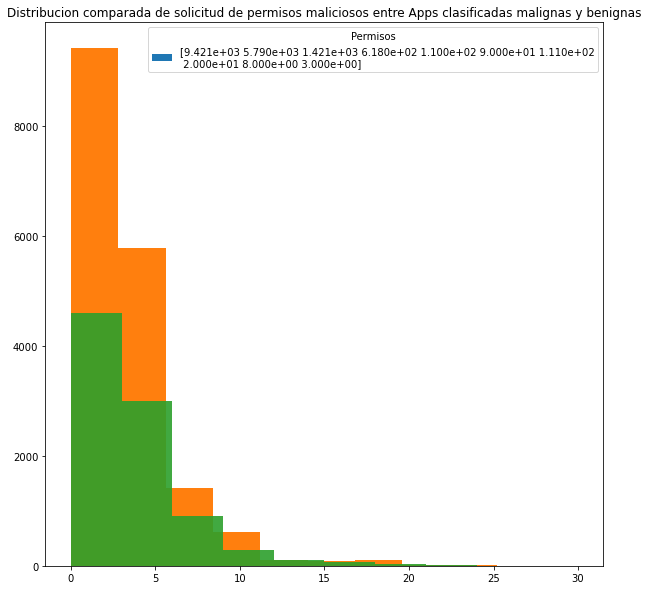

In [153]:
"""Hay una distribucion diferente entre la cantidad de permisos peligrosos para las aplicaciones malignas de las benignas?"""
fig = plt.figure(figsize = [10,10])
ax = plt.axes(title = 'Distribucion comparada de solicitud de permisos maliciosos entre Apps clasificadas malignas y benignas')
etiquetas = ax.hist(df.loc[df.Class == 1,"Dangerous permissions count"]) 
ax.legend(etiquetas, loc='upper right', title = "Permisos", frameon=True);
#ax = plt.axes(title = 'Dangerous permissions')
# color amarillo malignas y color celeste benignas
ax.hist(df.loc[df.Class == 1,"Dangerous permissions count"])
ax.hist(df.loc[df.Class == 0,"Dangerous permissions count"],alpha = 0.9)

## A priori no parece haber una gran dirferencia en la cantidad de permisos peligrosos entre ambas clases

## Df de los permisos

In [154]:
permissions

,Original,Categoria,Nombre,Riesgo
0,Default : Access DRM content. (S),Default,Access DRM content. (S),Safe
1,Default : Access Email provider data (S),Default,Access Email provider data (S),Safe
2,Default : Access all system downloads (S),Default,Access all system downloads (S),Safe
3,Default : Access download manager. (S),Default,Access download manager. (S),Safe
4,Default : Advanced download manager functions....,Default,Advanced download manager functions. (S),Safe
...,...,...,...,...
168,Your personal information : retrieve system in...,Your personal information,retrieve system internal state (S),Safe
169,Your personal information : set alarm in alarm...,Your personal information,set alarm in alarm clock (S),Safe
170,Your personal information : write Browser's hi...,Your personal information,write Browser's history and bookmarks (D),Dangerous
171,Your personal information : write contact data...,Your personal information,write contact data (D),Dangerous


In [155]:
#Chequeando que el 100% de los permisos default sean safe
cat_def = permissions.Categoria.str.contains("Default")
permissions[cat_def].Riesgo.unique()

array(['Safe'], dtype=object)

## Cual es el top 5 de permisos que mas solicitan las aplicaciones malicioasas?

In [156]:
#pd.DataFrame(df.columns).to_csv('columns.csv')

In [157]:
df.shape[0]

26586

In [158]:
permisos_q = df.groupby(by = 'Class',axis=0).sum().transpose().reset_index().rename(columns={'index':'Original'})
permisos_q

Class,Original,0,1
0,Rating,35686.1,59079.50
1,Number of ratings,71436159.0,71331883.00
2,Price,0.0,15944.95
3,Dangerous permissions count,28669.0,52039.00
4,Safe permissions count,13477.0,21655.00
...,...,...,...
173,Your personal information : retrieve system in...,7.0,7.00
174,Your personal information : set alarm in alarm...,4.0,8.00
175,Your personal information : write Browser's hi...,249.0,147.00
176,Your personal information : write contact data...,392.0,643.00


In [159]:
df.shape[0]

26586

In [160]:
#permisos_q = permisos_q.loc[permisos_q.Original.str.contains('\)')]
permisos_q['penetracion_benignas'] = permisos_q[permisos_q.columns[1]]/df.shape[0]
permisos_q

Class,Original,0,1,penetracion_benignas
0,Rating,35686.1,59079.50,1.342289
1,Number of ratings,71436159.0,71331883.00,2686.984089
2,Price,0.0,15944.95,0.000000
3,Dangerous permissions count,28669.0,52039.00,1.078350
4,Safe permissions count,13477.0,21655.00,0.506921
...,...,...,...,...
173,Your personal information : retrieve system in...,7.0,7.00,0.000263
174,Your personal information : set alarm in alarm...,4.0,8.00,0.000150
175,Your personal information : write Browser's hi...,249.0,147.00,0.009366
176,Your personal information : write contact data...,392.0,643.00,0.014745


In [161]:
permisos_q['penetracion_malignas'] = permisos_q[permisos_q.columns[2]]/df.shape[0]
permisos_q['delta'] = abs(permisos_q['penetracion_benignas'] - permisos_q['penetracion_malignas'])
permisos_q.sort_values(by='delta', ascending = False)

Class,Original,0,1,penetracion_benignas,penetracion_malignas,delta
1,Number of ratings,71436159.0,71331883.00,2686.984089,2683.061875,3.922215
0,Rating,35686.1,59079.50,1.342289,2.222203,0.879914
3,Dangerous permissions count,28669.0,52039.00,1.078350,1.957384,0.879034
2,Price,0.0,15944.95,0.000000,0.599750,0.599750
4,Safe permissions count,13477.0,21655.00,0.506921,0.814526,0.307606
...,...,...,...,...,...,...
60,Default : run in factory test mode (S),0.0,0.00,0.000000,0.000000,0.000000
153,Your messages : Send Gmail (S),5.0,5.00,0.000188,0.000188,0.000000
155,Your messages : modify Gmail (D),5.0,5.00,0.000188,0.000188,0.000000
157,Your messages : read Gmail attachment previews...,0.0,0.00,0.000000,0.000000,0.000000


In [162]:
#Nos quedamos con las 5 principales variables safe con una variabilidad entre apps benignas 
#y malignas teniendo en cuenta el q para que sean representativas
mask_safe = (permissions.Original.loc[permissions.Riesgo == 'Safe']) 

In [163]:
list_top_permissions = permisos_q.loc[(permisos_q.Original.isin(mask_safe))&((permisos_q[permisos_q.columns[1]]>500)|(permisos_q[permisos_q.columns[2]]>500)),:].sort_values(by='delta',ascending = False).head(5).Original
list_top_permissions

85       Network communication : view network state (S)
73             Hardware controls : control vibrator (S)
84         Network communication : view Wi-Fi state (S)
93       System tools : automatically start at boot (S)
83    Network communication : receive data from Inte...
Name: Original, dtype: object

In [164]:
#Nos quedamos con las 5 principales variables unsafe con una variabilidad entre apps benignas 
#y malignas teniendo en cuenta el q para que sean representativas
mask_unsafe = permissions.Original.loc[permissions.Riesgo == 'Dangerous']
list_top_permissions = list_top_permissions.append(permisos_q.loc[(permisos_q.Original.isin(mask_unsafe))&((permisos_q[permisos_q.columns[1]]>500)|(permisos_q[permisos_q.columns[2]]>500)),:].sort_values(by='delta',ascending = False).head(3).Original)

In [165]:
#Me quedo solo con los 10 permisos con mayor variabilidad entre clases y con representatividad.
list_top_permissions

85        Network communication : view network state (S)
73              Hardware controls : control vibrator (S)
84          Network communication : view Wi-Fi state (S)
93        System tools : automatically start at boot (S)
83     Network communication : receive data from Inte...
81      Network communication : full Internet access (D)
91     Storage : modify/delete USB storage contents m...
150              Your location : fine (GPS) location (D)
Name: Original, dtype: object

In [166]:
permisos_q.Original.unique()

array(['Rating', 'Number of ratings', 'Price',
       'Dangerous permissions count', 'Safe permissions count',
       'Default : Access DRM content. (S)',
       'Default : Access Email provider data (S)',
       'Default : Access all system downloads (S)',
       'Default : Access download manager. (S)',
       'Default : Advanced download manager functions. (S)',
       'Default : Audio File Access (S)',
       'Default : Install DRM content. (S)',
       'Default : Modify Google service configuration (S)',
       'Default : Modify Google settings (S)',
       'Default : Move application resources (S)',
       'Default : Read Google settings (S)',
       'Default : Send download notifications. (S)',
       'Default : Voice Search Shortcuts (S)',
       'Default : access SurfaceFlinger (S)',
       'Default : access checkin properties (S)',
       'Default : access the cache filesystem (S)',
       'Default : access to passwords for Google accounts (S)',
       'Default : act as an ac

## Tiene algo que ver la cantidad de permisos por categoria con el target?
#### Vamos a generar primero la cantidad de permisos por categoria de las que definimos antes:

+ Default 
+ Development tools
+ Hardware controls 
+ Network communication 
+ Phone calls 
+ Services that cost you money 
+ Storage 
+ System tools 
+ Your accounts 
+ Your location 
+ Your messages 
+ Your personal information 

In [167]:
#Diccionario para poder filtrar columnas de permisos
dic_permissions = {"Default": df.columns.str.contains("Default"),
                  "Development tools": df.columns.str.contains("Development tools"),
                  "Hardware controls": df.columns.str.contains("Hardware controls"),
                  "Network communication": df.columns.str.contains("Network communication"),
                  "Phone calls": df.columns.str.contains("Phone calls"),
                  "Services that cost you money": df.columns.str.contains("Services that cost you money"),
                  "Storage": df.columns.str.contains("Storage"),
                  "System tools": df.columns.str.contains("System tools"),
                  "Your accounts": df.columns.str.contains("Your accounts"),
                  "Your location": df.columns.str.contains("Your location"),
                  "Your messages": df.columns.str.contains("Your messages"),
                  "Your personal information": df.columns.str.contains("Your personal information")}

In [168]:
df_p = pd.DataFrame(df.apply(lambda x : np.sum(x.loc[dic_permissions["Default"]]), axis= 1),columns = ['#Permissions_Default'])

In [169]:
df_p

,#Permissions_Default
0,0
1,0
2,0
3,0
5,0
...,...
29993,0
29994,1
29995,0
29997,0


In [170]:
df_p['#Permissions_Dev_tools'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Development tools"]]), axis= 1)
df_p['#Permissions_Hard_controls'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Hardware controls"]]), axis= 1)
df_p['#Permissions_Net_comm'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Network communication"]]), axis= 1)
df_p['#Permissions_Phone_calls'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Phone calls"]]), axis= 1)
df_p['#Permissions_Serv_money'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Services that cost you money"]]), axis= 1)
df_p['#Permissions_Storage'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Storage"]]), axis= 1)
df_p['#Permissions_System_tools'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["System tools"]]), axis= 1)
df_p['#Permissions_Your_accounts'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Your accounts"]]), axis= 1)
df_p['#Permissions_Your_location'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Your location"]]), axis= 1)
df_p['#Permissions_Your_messages'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Your messages"]]), axis= 1)
df_p['#Permissions_Your_per_info'] = df.apply(lambda x : np.sum(x.loc[dic_permissions["Your personal information"]]), axis= 1)

In [171]:
df = df.join(df_p)

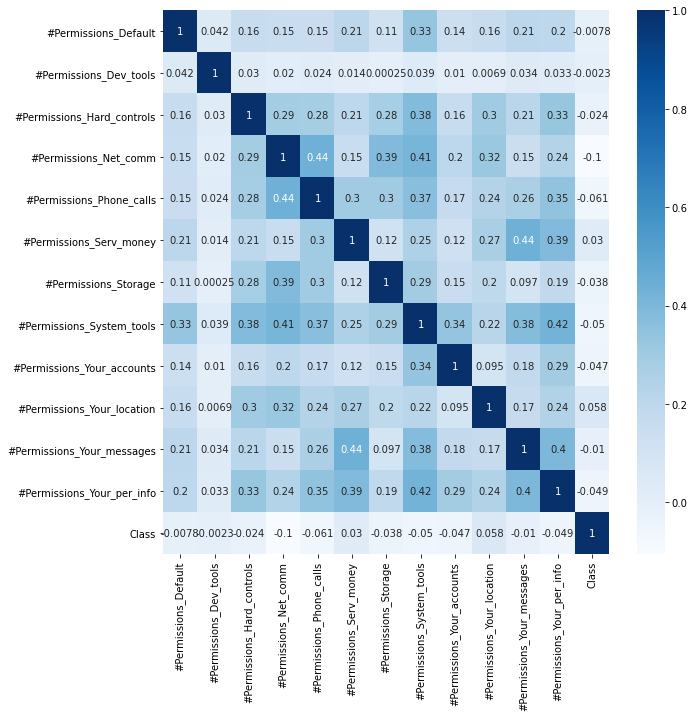

In [172]:
plt.figure(figsize = [10,10])
sns.heatmap(df.loc[:,['#Permissions_Default','#Permissions_Dev_tools','#Permissions_Hard_controls', '#Permissions_Net_comm',
       '#Permissions_Phone_calls', '#Permissions_Serv_money',
       '#Permissions_Storage', '#Permissions_System_tools',
       '#Permissions_Your_accounts', '#Permissions_Your_location',
       '#Permissions_Your_messages', '#Permissions_Your_per_info','Class']].corr(),cmap = 'Blues',annot = True)

## No hay correlaciones muy claras pero si se puede empezar a intuir que hay determinadas variables de permisos que nos pueden aportar poco al resultado del modelo. Como por ejemplo la categoria Default, o Dev tools

In [173]:
list_top_permissions.values

array(['Network communication : view network state (S)',
       'Hardware controls : control vibrator (S)',
       'Network communication : view Wi-Fi state (S)',
       'System tools : automatically start at boot (S)',
       'Network communication : receive data from Internet (S)',
       'Network communication : full Internet access (D)',
       'Storage : modify/delete USB storage contents modify/delete SD card contents (D)',
       'Your location : fine (GPS) location (D)'], dtype=object)

In [174]:
columnas_mask = df.columns.isin(['App',
                'Description',
                'Category',
                'Rating',
                'Number of ratings',
                'Price',
                'Related apps',
                'Package',
                'Dangerous permissions count',
                'Safe permissions count',
                '#Permissions_Default',
                '#Permissions_Dev_tools',
                '#Permissions_Hard_controls',
                '#Permissions_Net_comm',
                '#Permissions_Phone_calls',
                '#Permissions_Serv_money',
                '#Permissions_Storage',
                '#Permissions_System_tools',
                '#Permissions_Your_accounts',
                '#Permissions_Your_location',
                '#Permissions_Your_messages',
                '#Permissions_Your_per_info',
                'Network communication : view network state (S)',
                'Hardware controls : control vibrator (S)',
                'Network communication : view Wi-Fi state (S)',
               'System tools : automatically start at boot (S)',
               'Your location : access extra location provider commands (S)',
               'Network communication : full Internet access (D)',
               'Storage : modify/delete USB storage contents modify/delete SD card contents (D)',
               'Your location : fine (GPS) location (D)',
               'Phone calls : read phone state and identity (D)',
               'Your location : coarse (network-based) location (D)',
                'Class'
])

In [175]:
df = df.loc[:,columnas_mask]
df

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,#Permissions_Hard_controls,#Permissions_Net_comm,#Permissions_Phone_calls,#Permissions_Serv_money,#Permissions_Storage,#Permissions_System_tools,#Permissions_Your_accounts,#Permissions_Your_location,#Permissions_Your_messages,#Permissions_Your_per_info
0,Canada Post Corporation,com.canadapost.android,Business,Canada Post Mobile App gives you access to som...,3.1,77,0.00,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,...,0,2,0,1,1,1,0,1,0,2
1,Word Farm,com.realcasualgames.words,Brain & Puzzle,Speed and strategy combine in this exciting wo...,4.3,199,0.00,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2,...,0,2,1,0,1,0,1,0,0,0
2,Fortunes of War FREE,fortunesofwar.free,Cards & Casino,"Fortunes of War is a fast-paced, easy to learn...",4.1,243,0.00,"{com.kevinquan.condado, hu.monsta.pazaak, net....",1.0,1,...,0,2,0,0,0,0,0,0,0,0
3,Better Keyboard: Avatar Purple,com.cc.betterkeyboard.skins.avatarpurple,Libraries & Demo,Skin for Better Keyboard featuring a glossy fe...,3.6,2589,0.00,{eu.gdumoulin.betterandroid.skins.transparent....,0.0,0,...,0,0,0,0,0,0,0,0,0,0
5,Ms Claus Live Wallpaper,tmc.christmaslady.livewallpaper,Personalization,Ms Claus Live Wallpaper<p>Find more Free apps ...,4.5,16,0.00,"{tmc.christmassanta.livewallpaper, tmc.winterh...",3.0,1,...,0,2,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,FORUM CU Mobile DeposZip,com.Vertifi.DeposZip.P274074037,Finance,Make check deposits to your FORUM Credit Union...,4.8,4,0.00,"{com.forumcu.cuonline, com.msi.bktest, com.qua...",2.0,0,...,1,1,0,0,0,0,0,0,0,0
29994,Beechwood Hotel,smartstay.beechwood,Travel & Local,"Beechwood is an Android hotel app for guests, ...",5.0,2,0.00,"{com.bluewaterpages, com.travelconnection.luxu...",3.0,1,...,0,1,0,1,0,0,0,1,0,0
29995,ZDefense: Tower Defense,mobi.zstudio.avi.full,Arcade & Action,Explosive Tower Defense!<p>Top Tower Defense G...,4.6,56,2.99,"{com.entwicklerx.swampdefense, com.digimentgam...",3.0,3,...,0,3,0,0,1,1,1,0,0,0
29997,Ambassador Hotel Taipei,VMC.Ambassadorhotel,Travel & Local,Key features of this App: <br>1. View photos o...,3.4,5,0.00,"{com.hyxen.app.NewTaipeiTravel, j2ab.android.t...",3.0,0,...,0,1,0,0,0,0,0,2,0,0


## Variables que no dummy 

In [176]:
df.iloc[:,[0,1,2,3,4,5,6,7,8,9]].head()

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count
0,Canada Post Corporation,com.canadapost.android,Business,Canada Post Mobile App gives you access to som...,3.1,77,0.0,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1
1,Word Farm,com.realcasualgames.words,Brain & Puzzle,Speed and strategy combine in this exciting wo...,4.3,199,0.0,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2
2,Fortunes of War FREE,fortunesofwar.free,Cards & Casino,"Fortunes of War is a fast-paced, easy to learn...",4.1,243,0.0,"{com.kevinquan.condado, hu.monsta.pazaak, net....",1.0,1
3,Better Keyboard: Avatar Purple,com.cc.betterkeyboard.skins.avatarpurple,Libraries & Demo,Skin for Better Keyboard featuring a glossy fe...,3.6,2589,0.0,{eu.gdumoulin.betterandroid.skins.transparent....,0.0,0
5,Ms Claus Live Wallpaper,tmc.christmaslady.livewallpaper,Personalization,Ms Claus Live Wallpaper<p>Find more Free apps ...,4.5,16,0.0,"{tmc.christmassanta.livewallpaper, tmc.winterh...",3.0,1


## Las variables no dummies tenemos algunas que no podemos utilizar, ya que a nuevas aplicaciones no tendriamos dichas features

In [177]:
#No tendriamos un Rating, ya que esta informacion estaria disponible una vez implementada en la google store
#Por consiguiente tampoco tendriamos un numero de raitings
df.drop(['Rating','Number of ratings'],axis = 1,inplace = True)

In [178]:
#Por otro lado tenemos una variable package que si bien en terminos de seguridad informatica se podrian filtrar 
#algunos packetes conocidos de antemano como potencialmente peligrosos, en lo que concierne a un algoritmo predictivo
#carece de importancia.
df.drop('Package',axis =1,inplace=True)

In [179]:
#Tenemos algun nombre de app con mucha frecuencia?
df.App.value_counts()

Tic Tac Toe                       44
????????????                      24
??????????????????                15
Tic-Tac-Toe                       13
Daily Horoscope                   13
                                  ..
ParisGo                            1
China-ASEAN Free Trade Area        1
Pocket MadLibs                     1
Poker Session Logger               1
Dancing Turkeys Live Wallpaper     1
Name: App, Length: 22176, dtype: int64

In [180]:
#Identificacion de patrones raros en nombre:
df.loc[df.App.str.contains("\?{4,}"),'Class'].value_counts(normalize = True)

1    0.736342
0    0.263658
Name: Class, dtype: float64

## Las aplicaciones que tienen 4 o mas singos de interrogacion tienen una distribucion mas inclinada a ser malignas, sin embargo cuantitativamente no es demasiado representativo. De todas formas probamos la variable

In [181]:
#Flag signo de interrogacion
df['flag_interrogacion'] = df.loc[df.App.str.contains("\?{4,}"),'Class']

In [182]:
df['flag_interrogacion'] = df.apply(lambda x: 1 if x.flag_interrogacion == 1 else 0, axis=1)

In [183]:
#Categorias 
s_total = df.Category.value_counts(normalize =True).round(2)
s_malic = df.loc[df.Class == 1,'Category'].value_counts(normalize=True).round(2)
s_benig = df.loc[df.Class == 0,'Category'].value_counts(normalize=True).round(2)

In [184]:
df_compare_categorys = pd.DataFrame(s_total)
df_compare_categorys.rename(columns = {'Category':'distribucion_general'},inplace = True)
df_compare_categorys['distribucion_maliciosas'] = s_malic
df_compare_categorys['distribucion_benignas'] = s_benig
df_compare_categorys['delta'] = df_compare_categorys.distribucion_maliciosas - df_compare_categorys.distribucion_benignas
df_compare_categorys.sort_values(by = 'delta', ascending = False, inplace = True)
df_compare_categorys
# Como leer esta tabla: 1 col indica la participacion de la cat evaluada en el total gral, x ejm travel& locl tiene el 7% de todas las apps 
# analizadas. 2 Col indica el % de apps clasificadas malicionas de las cat analizada, x ejm en travel & local estan el 11% de las apps
# maliciosas. 3 Col indica el % de apps clisificadas como benignas, x ejm travel & local no hay ninguna clisf como beningna
# 4 Col indica la variacion entre el % de las apps clasif como maliciosas y % de las apps clasif como benignas
# La cat mas desbalanceada es la travel & local que tiene todas las apps clasif maligna y ninguna beningna

,distribucion_general,distribucion_maliciosas,distribucion_benignas,delta
Travel & Local,0.07,0.11,0.00,0.11
Entertainment,0.09,0.11,0.06,0.05
Tools,0.04,0.06,0.02,0.04
Sports,0.02,0.03,0.00,0.03
Shopping,0.01,0.02,0.00,0.02
Transportation,0.01,0.02,0.00,0.02
News & Magazines,0.02,0.02,0.00,0.02
Productivity,0.02,0.03,0.01,0.02
Books & Reference,0.07,0.07,0.06,0.01
Medical,0.01,0.01,0.00,0.01


Text(0.5, 1.0, 'Analisis de variacion IntraCategoria entre participacion de apps maliciosas y no malicionas')

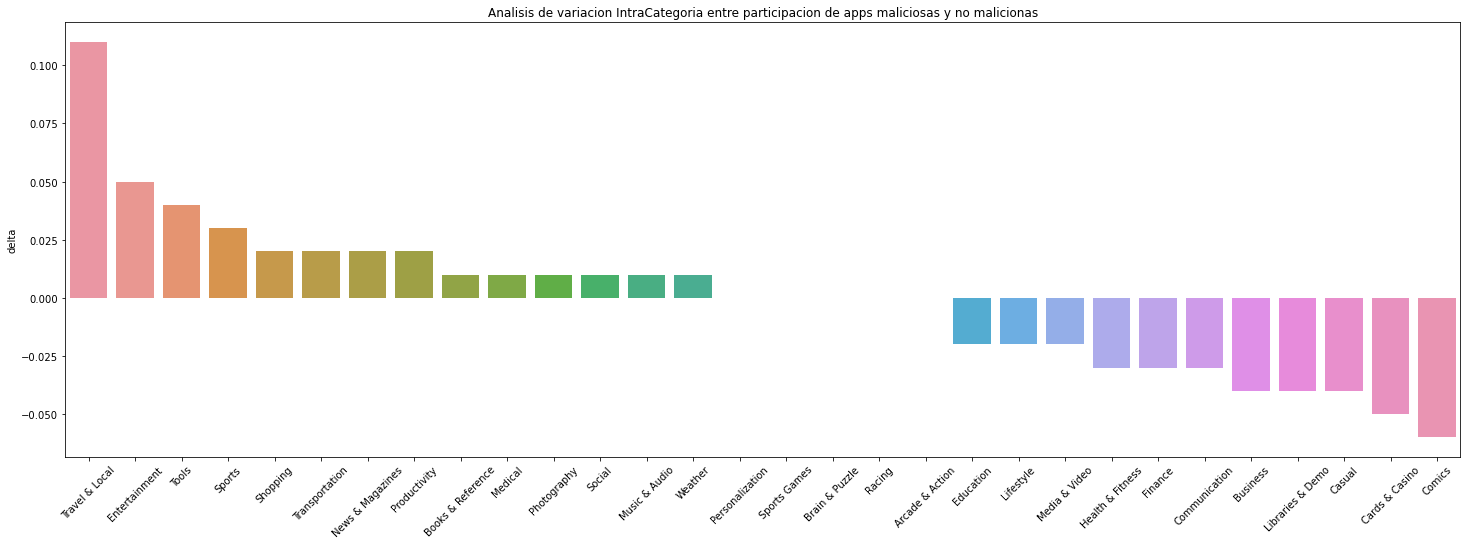

In [185]:
plt.figure(figsize = [25,8],)
plt.xticks(rotation=45)
D=sns.barplot(x = df_compare_categorys.index, y = df_compare_categorys.delta,)
D.set_title("Analisis de variacion IntraCategoria entre participacion de apps maliciosas y no malicionas")

## Para los positivos indica una mayor penetracion de apps maliciosas en la categoria, una mayor penetracion en la categoria travel & local podria dar a entender que estas aplicaciones son las mas propensas a tener intenciones malignas. No lo podemos afirmar ya que no tenemos conocimiento pleno de como esta hecho el muestreo, seria mas bien como una primera impresion.

In [186]:
#Hago variables dummies de las categorias
df = pd.get_dummies(df,columns = ['Category'],drop_first = True)

## Analisis de la variable precio

In [40]:
#Inspeccionando un poco la variable precio por clase...
df.groupby(by = 'Class').Price.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,8994.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
1,17592.0,0.906375,4.030299,0.0,0.0,0.0,0.99,158.07


Text(0.5, 1.0, 'Analisis de correlacion precio clasificacion')

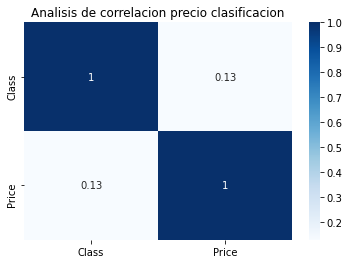

In [41]:
#Precio
vp=sns.heatmap(df.loc[:,['Class','Price']].corr(),annot = True, cmap = 'Blues')
vp.set_title("Analisis de correlacion precio clasificacion")

## La variable precio solo tiene valor para las aplicaciones maliciosas por lo tanto queda descartada, para evitar que el modelo no este sesgado ya que no es correcto asumir que todas las aplicaciones benignas son gratuitas

In [187]:
#Dropeo variable precio
df.drop(labels=['Price'],axis = 1, inplace = True)
df

,App,Description,Related apps,Dangerous permissions count,Safe permissions count,Hardware controls : control vibrator (S),Network communication : full Internet access (D),Network communication : view Wi-Fi state (S),Network communication : view network state (S),Phone calls : read phone state and identity (D),...,Category_Productivity,Category_Racing,Category_Shopping,Category_Social,Category_Sports,Category_Sports Games,Category_Tools,Category_Transportation,Category_Travel & Local,Category_Weather
0,Canada Post Corporation,Canada Post Mobile App gives you access to som...,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Word Farm,Speed and strategy combine in this exciting wo...,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Fortunes of War FREE,"Fortunes of War is a fast-paced, easy to learn...","{com.kevinquan.condado, hu.monsta.pazaak, net....",1.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Better Keyboard: Avatar Purple,Skin for Better Keyboard featuring a glossy fe...,{eu.gdumoulin.betterandroid.skins.transparent....,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Ms Claus Live Wallpaper,Ms Claus Live Wallpaper<p>Find more Free apps ...,"{tmc.christmassanta.livewallpaper, tmc.winterh...",3.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,FORUM CU Mobile DeposZip,Make check deposits to your FORUM Credit Union...,"{com.forumcu.cuonline, com.msi.bktest, com.qua...",2.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,Beechwood Hotel,"Beechwood is an Android hotel app for guests, ...","{com.bluewaterpages, com.travelconnection.luxu...",3.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29995,ZDefense: Tower Defense,Explosive Tower Defense!<p>Top Tower Defense G...,"{com.entwicklerx.swampdefense, com.digimentgam...",3.0,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
29997,Ambassador Hotel Taipei,Key features of this App: <br>1. View photos o...,"{com.hyxen.app.NewTaipeiTravel, j2ab.android.t...",3.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Campo description

In [188]:
# Mostramos un ejemplo del contenido de la columna descripcion en una columna al azar (la observacion 520)
# como podemos observar el texto de la observacin esta escrito en formato HTML, con lo cual deberemos eliminar todos los caracteres de este 
# formato lo haremos mediante un diccionario de stopwords
df.Description[520]

"Guns & Cars & Fun! Pure car shooting action in 3D!<p>Awesome racing and arcade game remaining such famous titles as GTA, Carmageddon, Test Drive and Street Rod series. Trading, global leaderboards, 16 upgradable cars, 16 different missions, unique gameplay, awesome graphics and fabulous soundtrack. Try ski jumping, taxi driving, destroying enemies using weapons! Cardboard Cars & Guns! Game of the 2011.<p>You can remove in game advert by clicking on it!<br>Then press &quot;back&quot; to return to game!<p>------<br>IMPORTANT! FOR ANDROID 3.X (i.e. galaxy tab 10.1) If you have problems with running the game, when application shows splash screen, press home key then run the game again it should work. Let us know if you face any problems.<p>---<br>Version 1.15 - 2 new cars (Ghosthunter & Cool Car Of Death) and 3 new Halloween missions<br>Version 1.142 - 2 new missions<br>Version 1.14 - 2 new cars (The A-Van & Truck) + 1 new mission - jump over cars<br>Version 1.13 - 2 new cars (Batcar'89 &

In [189]:
# Se importan las librerias word tokenize, SnawballStemmer, stopwords y WorldCloud 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
# Cargamos el diccionario de stopwords
stopwords_en = stopwords.words('english')
stopwords_en.append('p')
stopwords_en.append('br')
stopwords_en.append('quot')
stopwords_en.append('google')
stopwords_en.append(' google')
stopwords_en.append('google ')
stopwords_en.append('android')
stopwords_en.append('href')
stopwords_en.append('app')
stopwords_en.append('blank')
stopwords_en.append('keyword')
stopwords_en.append('support')
stopwords_en.append('feature')
stopwords_en.append('type')
stopwords_en.append('url')
stopwords_en.append('_blank')
stopwords_en.append('target')
stopwords_en.append('q')
stopwords_en.append('q')
stopwords_en.append('http')
stopwords_en.append('com')
stopwords_en.append('â')
stopwords_en.append('www')
# Armamos una funcion que tokeniza hace stemizacion y elimina los stopwords, en definitiva crea un diccionario 
def word_cloud(corpus):
    tokens = [word_tokenize(doc) for doc in corpus]
    flat_tokens = [item for sublist in tokens for item in sublist]
    english_stemmer = SnowballStemmer('english', ignore_stopwords = False)
    stem_tokens = [english_stemmer.stem(x) for x in flat_tokens]
    stopwords_en_stem = [english_stemmer.stem(x) for x in stopwords_en]
    stem_tokens_non_stopwords = [x for x in stem_tokens if x not in stopwords_en_stem]
    mi_texto = ' '.join(stem_tokens_non_stopwords) 
    return mi_texto

In [190]:
def transform_format(val):
    if val != 0:
        return 255
    else:
        return val

In [191]:
def transform_format2(val):
    if val == 0:
        return 255
    else:
        return val

In [192]:
from PIL import Image
danger_mask = np.array(Image.open("virus.png"))
ok_mask = np.array(Image.open("pulgar.png"))
for i in range(len(danger_mask)):
    danger_mask[i] = list(map(transform_format, danger_mask[i]))
    
for i in range(len(ok_mask)):
    ok_mask[i] = list(map(transform_format2, ok_mask[i]))

FileNotFoundError: [Errno 2] No such file or directory: 'virus.png'

In [48]:
ok_mask

array([[  1,   1,   1, ..., 255, 255, 255],
       [  1,   1,   1, ..., 255, 255, 255],
       [  1,   1,   1, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   1,   1,   1],
       [255, 255, 255, ...,   1,   1,   1],
       [255, 255, 255, ...,   1,   1,   1]], dtype=uint8)

In [49]:
# Para hacer mas performante a la hora de testear la nube de palabras 
# muestreo al 10% cada clase y obtengo sus descriptions
corpus_benignas = df.loc[df.Class == 0, 'Description'].sample(frac = 0.05)
corpus_malignas = df.loc[df.Class == 1,'Description'].sample(frac = 0.05)

#corpus_benignas = df.loc[df.Class == 0, 'Description']
#corpus_malignas = df.loc[df.Class == 1,'Description']
nube_palabras_benignas = WordCloud(width=1500, height=1500, margin=0, stopwords = stopwords_en, mask = ok_mask).generate(word_cloud(corpus_benignas)) 
nube_palabras_malignas = WordCloud(width=1500, height=1500, margin=0, stopwords = stopwords_en, mask = danger_mask).generate(word_cloud(corpus_malignas))

In [50]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

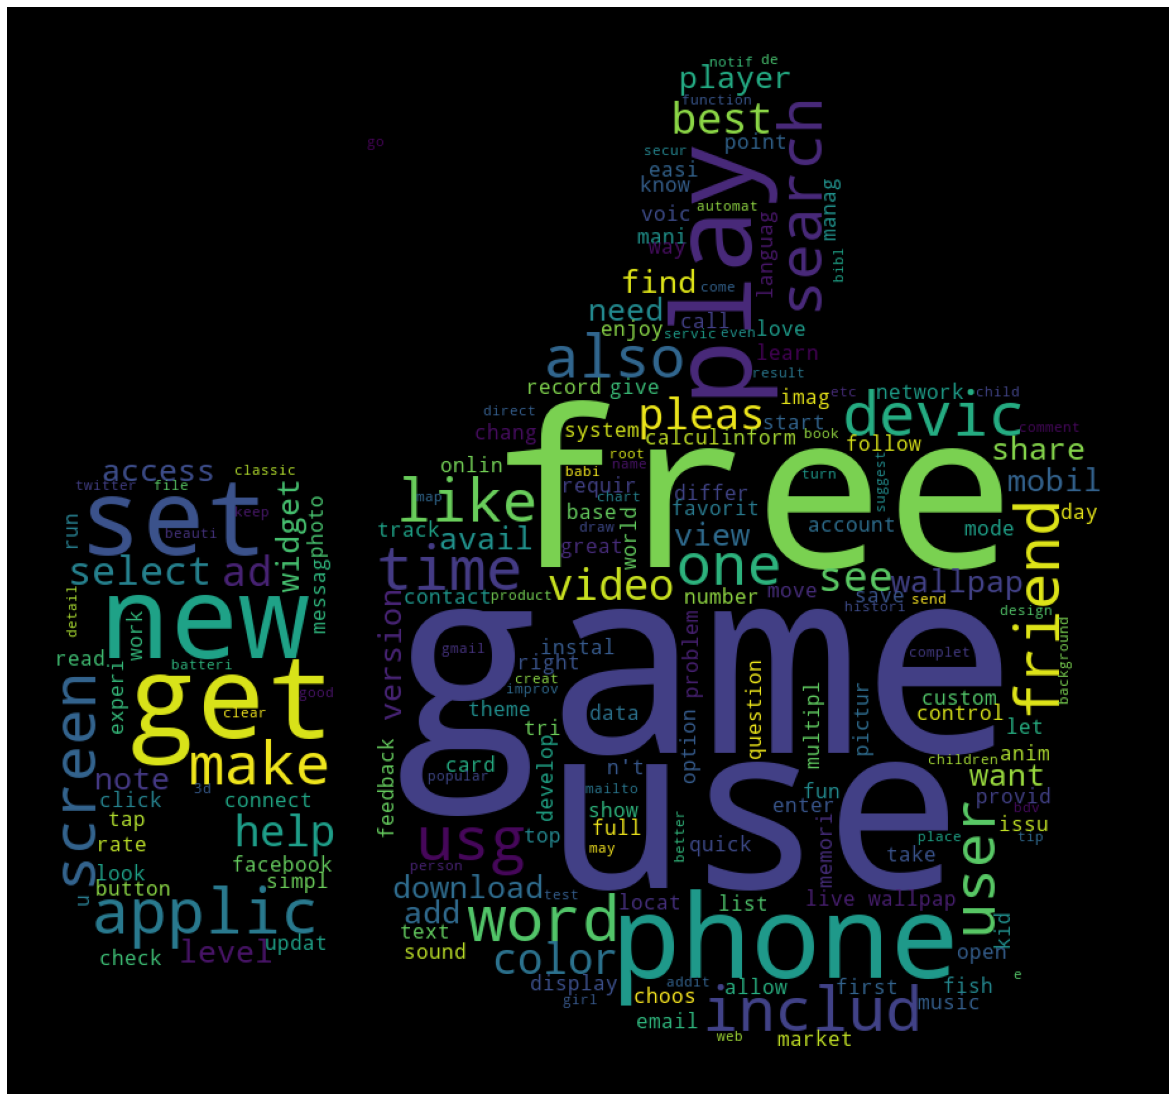

In [51]:
plot_cloud(nube_palabras_benignas)

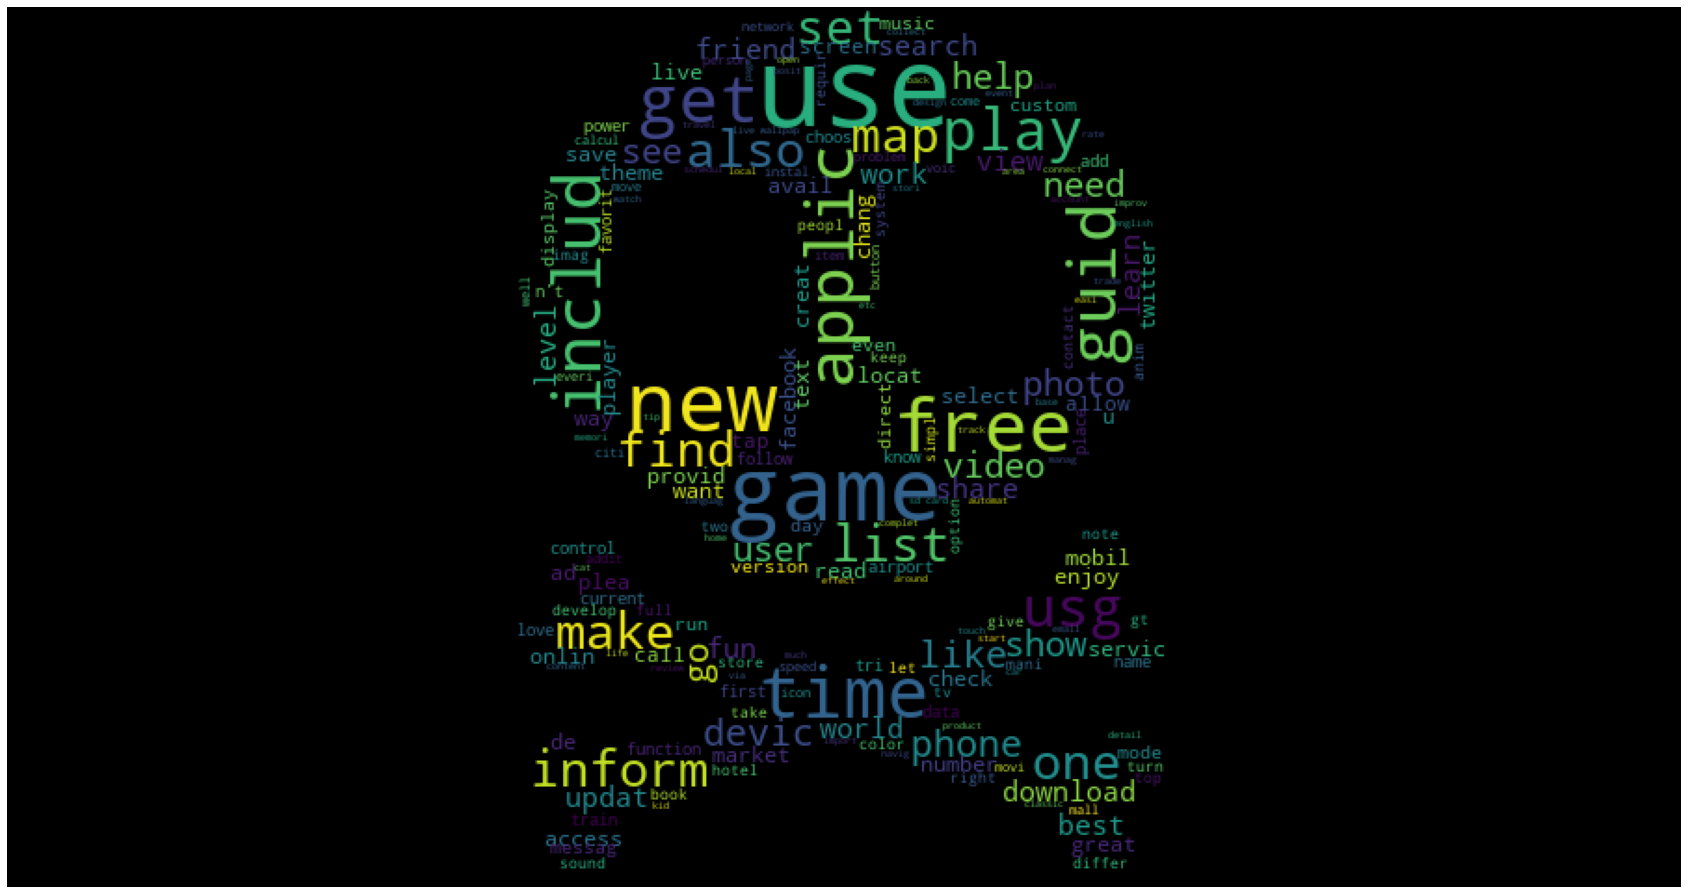

In [52]:
plot_cloud(nube_palabras_malignas)

## A priori no se ve ninguna palabra en particular que nos permita diferenciar una descripcion de aplicacion maligna vs aplicacion benigna. Por lo tanto no vamos a utilizar este campo

In [195]:
df

,App,Description,Related apps,Dangerous_permissions_count,Safe_permissions_count,Hardware_controls_control_vibrator,Network_communication_full_Internet_access,Network_communication_view_Wi_Fi_state,Network_communication_view_network_state,Phone_calls_read_phone_state_and_identity,...,Category_Productivity,Category_Racing,Category_Shopping,Category_Social,Category_Sports,Category_Sports_Games,Category_Tools,Category_Transportation,Category_Travel_Local,Category_Weather
0,Canada Post Corporation,Canada Post Mobile App gives you access to som...,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Word Farm,Speed and strategy combine in this exciting wo...,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Fortunes of War FREE,"Fortunes of War is a fast-paced, easy to learn...","{com.kevinquan.condado, hu.monsta.pazaak, net....",1.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Better Keyboard: Avatar Purple,Skin for Better Keyboard featuring a glossy fe...,{eu.gdumoulin.betterandroid.skins.transparent....,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Ms Claus Live Wallpaper,Ms Claus Live Wallpaper<p>Find more Free apps ...,"{tmc.christmassanta.livewallpaper, tmc.winterh...",3.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,FORUM CU Mobile DeposZip,Make check deposits to your FORUM Credit Union...,"{com.forumcu.cuonline, com.msi.bktest, com.qua...",2.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,Beechwood Hotel,"Beechwood is an Android hotel app for guests, ...","{com.bluewaterpages, com.travelconnection.luxu...",3.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29995,ZDefense: Tower Defense,Explosive Tower Defense!<p>Top Tower Defense G...,"{com.entwicklerx.swampdefense, com.digimentgam...",3.0,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
29997,Ambassador Hotel Taipei,Key features of this App: <br>1. View photos o...,"{com.hyxen.app.NewTaipeiTravel, j2ab.android.t...",3.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [196]:
#Related apps, apps, y description quedan descartadas
df.drop(labels = ['App','Related apps','Description'], axis =1, inplace = True)

## Dataframe final

In [197]:
df

,Dangerous_permissions_count,Safe_permissions_count,Hardware_controls_control_vibrator,Network_communication_full_Internet_access,Network_communication_view_Wi_Fi_state,Network_communication_view_network_state,Phone_calls_read_phone_state_and_identity,Storage_modify_delete_USB_storage,System_tools_automatically_start,Your_location_access_extra,...,Category_Productivity,Category_Racing,Category_Shopping,Category_Social,Category_Sports,Category_Sports_Games,Category_Tools,Category_Transportation,Category_Travel_Local,Category_Weather
0,7.0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,2.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,3.0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29995,3.0,3,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Modelos

In [198]:
df.rename(columns = {'Dangerous permissions count':'Dangerous_permissions_count',
                     'Safe permissions count':'Safe_permissions_count',
       'Hardware controls : control vibrator (S)':'Hardware_controls_control_vibrator',
       'Network communication : full Internet access (D)':'Network_communication_full_Internet_access',
       'Network communication : view Wi-Fi state (S)':'Network_communication_view_Wi_Fi_state',
       'Network communication : view network state (S)':'Network_communication_view_network_state',
       'Phone calls : read phone state and identity (D)':'Phone_calls_read_phone_state_and_identity',
       'Storage : modify/delete USB storage contents modify/delete SD card contents (D)':'Storage_modify_delete_USB_storage',
       'System tools : automatically start at boot (S)':'System_tools_automatically_start',
       'Your location : access extra location provider commands (S)':'Your_location_access_extra',
       'Your location : coarse (network-based) location (D)':'Your_location_coarse',
       'Your location : fine (GPS) location (D)':'Your location_fine_GPS',
       '#Permissions_Default':'Permissions_Default', '#Permissions_Dev_tools':'Permissions_Dev_tools',
       '#Permissions_Hard_controls':'Permissions_Hard_controls', '#Permissions_Net_comm':'Permissions_Net_comm',
       '#Permissions_Phone_calls':'Permissions_Phone_calls', '#Permissions_Serv_money':'Permissions_Serv_money',
       '#Permissions_Storage':'Permissions_Storage', '#Permissions_System_tools':'Permissions_System_tools',
       '#Permissions_Your_accounts':'Permissions_Your_accounts', '#Permissions_Your_location':'Permissions_Your_location',
       '#Permissions_Your_messages':'Permissions_Your_messages', '#Permissions_Your_per_info':'Permissions_Your_per_info',
       'Category_Books & Reference':'Category_Books_Reference',
       'Category_Brain & Puzzle':'Category_Brain_Puzzle',
       'Category_Cards & Casino':'Category_Cards_Casino',
       'Category_Health & Fitness':'Category_Health_Fitness', 'Category_Libraries & Demo':'Category_Libraries_Demo',
       'Category_Media & Video':'Category_Media_Video',
       'Category_Music & Audio':'Category_Music_Audio', 'Category_News & Magazines':'Category_News_Magazines',
        'Category_Sports Games':'Category_Sports_Games',
       'Category_Travel & Local':'Category_Travel_Local'}, inplace = True)

In [199]:
#Primero divido el dataset en train y test
from sklearn.model_selection import train_test_split


X= df.loc[:,~df.columns.isin(['Class'])]
y = df.loc[:,'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1658, stratify = y)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17812, 54)

(8774, 54)

(17812,)

(8774,)

In [200]:
#Chequeamos mantener la misma participacion
display(y_train.value_counts(normalize = True),y_test.value_counts(normalize = True))

1    0.661689
0    0.338311
Name: Class, dtype: float64

1    0.661728
0    0.338272
Name: Class, dtype: float64

In [59]:
#Balanceo las clases de train
from imblearn.under_sampling import RandomUnderSampler

undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

In [60]:
display(y_train_us.value_counts(normalize = True),y_train_us.value_counts(normalize = True))

1    0.5
0    0.5
Name: Class, dtype: float64

1    0.5
0    0.5
Name: Class, dtype: float64

In [61]:
y_train_us.value_counts()

1    6026
0    6026
Name: Class, dtype: int64

In [62]:
#Ya con los datasets balanceados y con datos suficientes 6k por clase paso a entrenar los modelos seleccionados
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score, recall_score,confusion_matrix,roc_auc_score
import lightgbm as lgb 
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [63]:
#Preparo funcion para medicion de las principales metricas
def medicion(y_true,y_pred):
    print("Principales metricas: \n",classification_report(y_true, y_pred),"\n")
    print("------------------------------------------------------------------------\n")
    print("Area bajo la curva de roc:",round(roc_auc_score(y_true,y_pred),2),"\n")
    print("------------------------------------------------------------------------\n")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues',fmt='4d')
    plt.xlabel('Predichos')
    plt.ylabel('Reales')

In [64]:
#Preparo los folds para CV
folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 10541)

In [65]:
max_depth = np.arange(1,100)
max_depth = np.append(max_depth, -1)

# Logistic regression

In [66]:
#Logistic regression
#Defino pipe de logit
logit = LogisticRegression(random_state = 1,penalty = 'l2') 
pasos = [('preprocesamiento',StandardScaler()),('estimator',logit)]
pipe_logit = Pipeline(pasos)

In [67]:
#Defino la grilla para testear

grilla_cv = {'preprocesamiento':[StandardScaler(),MinMaxScaler()],
            'estimator__C':np.arange(0.01,0.9,0.1),
            'estimator__max_iter':np.arange(5000,10000)}

logit_cv = RandomizedSearchCV(estimator = pipe_logit,param_distributions = grilla_cv,scoring = 'recall', cv = folds, n_iter = 5)

In [68]:
logit_cv.fit(X_train_us,y_train_us)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10541, shuffle=True),
                   estimator=Pipeline(steps=[('preprocesamiento',
                                              StandardScaler()),
                                             ('estimator',
                                              LogisticRegression(random_state=1))]),
                   n_iter=5,
                   param_distributions={'estimator__C': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81]),
                                        'estimator__max_iter': array([5000, 5001, 5002, ..., 9997, 9998, 9999]),
                                        'preprocesamiento': [StandardScaler(),
                                                             MinMaxScaler()]},
                   scoring='recall')

In [69]:
logit_cv.best_estimator_

Pipeline(steps=[('preprocesamiento', MinMaxScaler()),
                ('estimator',
                 LogisticRegression(C=0.81, max_iter=5088, random_state=1))])

In [70]:
logit_cv.best_params_

{'preprocesamiento': MinMaxScaler(),
 'estimator__max_iter': 5088,
 'estimator__C': 0.81}

In [71]:
logit_cv.best_score_

0.6873514487363844

In [72]:
y_pred = logit_cv.predict(X_train)

Principales metricas: 
               precision    recall  f1-score   support

           0       0.55      0.74      0.63      6026
           1       0.84      0.69      0.75     11786

    accuracy                           0.70     17812
   macro avg       0.69      0.71      0.69     17812
weighted avg       0.74      0.70      0.71     17812
 

------------------------------------------------------------------------

Area bajo la curva de roc: 0.71 

------------------------------------------------------------------------



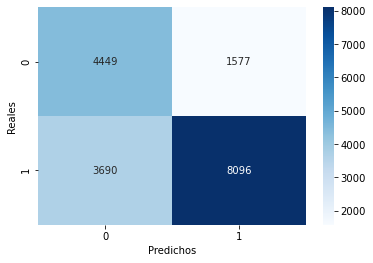

In [73]:
medicion(y_train,y_pred)

# Bayes

In [74]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score, recall_score,confusion_matrix,roc_auc_score

In [75]:
model = MultinomialNB()

In [76]:
pasos = [('preprocesamiento',MinMaxScaler()),('estimator',MultinomialNB())]
pipe_logit = Pipeline(pasos)

In [77]:
pipe_logit.fit(X_train_us,y_train_us)

Pipeline(steps=[('preprocesamiento', MinMaxScaler()),
                ('estimator', MultinomialNB())])

In [78]:
y_pred = pipe_logit.predict(X_train)

Principales metricas: 
               precision    recall  f1-score   support

           0       0.52      0.75      0.61      6026
           1       0.83      0.64      0.72     11786

    accuracy                           0.68     17812
   macro avg       0.67      0.69      0.67     17812
weighted avg       0.72      0.68      0.69     17812
 

------------------------------------------------------------------------

Area bajo la curva de roc: 0.69 

------------------------------------------------------------------------



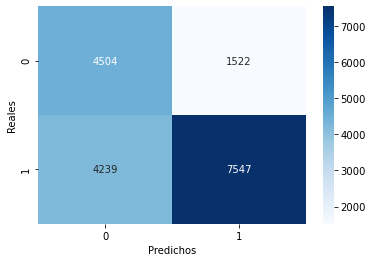

In [79]:
medicion(y_train,y_pred)

# LightGBM

In [143]:
#Primera prueba XGBoost lightgbm
#Defino pipe de lgb
pasos = [('preprocesamiento',StandardScaler()),('estimator',lgb.LGBMClassifier())]
pipe_lgb = Pipeline(pasos)

In [144]:
#Defino la grilla para testear

grilla_cv = {'preprocesamiento':[StandardScaler(),MinMaxScaler(),None],
            'estimator__num_leaves':np.arange(10,100),
            'estimator__max_depth':max_depth,
            'estimator__learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            #'estimator__bagging_fraction':[0.5,0.6,0.7,0.8,0.9], 
            #'estimator__feature_fraction':[0.5,0.6,0.7,0.8,0.9],
            'estimator__n_estimators':np.arange(1000)}

lgb_cv = RandomizedSearchCV(estimator = pipe_lgb,param_distributions = grilla_cv, cv = folds, scoring = 'recall', random_state = 2, n_iter = 10)

In [145]:
lgb_cv.fit(X_train_us,y_train_us)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10541, shuffle=True),
                   estimator=Pipeline(steps=[('preprocesamiento',
                                              StandardScaler()),
                                             ('estimator', LGBMClassifier())]),
                   param_distributions={'estimator__learning_rate': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5, 0.6,
                                                                     0.7, 0.8,
                                                                     0.9],
                                        'estimator__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21,...
                                        'estimator__num_leaves': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       

In [146]:
lgb_cv.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('estimator',
                 LGBMClassifier(learning_rate=0.2, max_depth=63,
                                n_estimators=741, num_leaves=33))])

In [147]:
lgb_cv.best_score_

0.6815526465127297

In [148]:
y_pred = lgb_cv.best_estimator_.predict(X_train)

Principales metricas: 
               precision    recall  f1-score   support

           0       0.62      0.84      0.72      6026
           1       0.90      0.74      0.81     11786

    accuracy                           0.77     17812
   macro avg       0.76      0.79      0.76     17812
weighted avg       0.81      0.77      0.78     17812
 

------------------------------------------------------------------------

Area bajo la curva de roc: 0.79 

------------------------------------------------------------------------



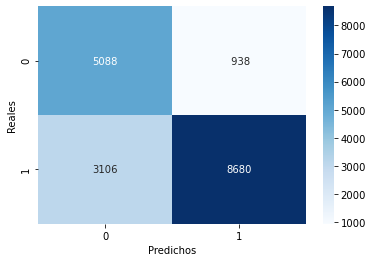

In [149]:
#AUC
medicion(y_train,y_pred)

# Catboost

In [87]:
#Primera prueba XGBoost catboost
#Defino pipe de catboost
model_cat = CatBoostClassifier()
pasos = [('preprocesamiento',StandardScaler()),('estimator',CatBoostClassifier(grow_policy = 'Lossguide',logging_level ='Silent'))]
pipe_cat = Pipeline(pasos)

In [88]:
grilla_cv = {'preprocesamiento':[StandardScaler(),MinMaxScaler(),None],
            'estimator__max_leaves':np.arange(1,100),
            'estimator__depth':np.arange(1,15),
            'estimator__learning_rate':np.arange(0.01,0.9,0.1),
            'estimator__iterations':np.arange(500)}
catboost_cv = RandomizedSearchCV(estimator = pipe_cat,param_distributions = grilla_cv, cv = folds, scoring = 'recall', random_state = 1, n_iter = 5)

In [89]:
catboost_cv.fit(X_train_us,y_train_us)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10541, shuffle=True),
                   estimator=Pipeline(steps=[('preprocesamiento',
                                              StandardScaler()),
                                             ('estimator',
                                              <catboost.core.CatBoostClassifier object at 0x000001FF76AB0550>)]),
                   n_iter=5,
                   param_distributions={'estimator__depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'estimator__iterations': array([  0,   1,...
                                        'estimator__max_leaves': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
      

In [90]:
catboost_cv.best_estimator_

Pipeline(steps=[('preprocesamiento', MinMaxScaler()),
                ('estimator',
                 <catboost.core.CatBoostClassifier object at 0x000001FF76AB0C70>)])

In [91]:
catboost_cv.best_score_

0.6830374704550338

In [92]:
y_pred_cat = catboost_cv.predict(X_train)

Principales metricas: 
               precision    recall  f1-score   support

           0       0.55      0.74      0.63      6026
           1       0.84      0.69      0.75     11786

    accuracy                           0.71     17812
   macro avg       0.69      0.71      0.69     17812
weighted avg       0.74      0.71      0.71     17812
 

------------------------------------------------------------------------

Area bajo la curva de roc: 0.71 

------------------------------------------------------------------------



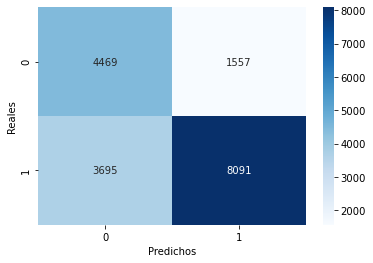

In [93]:
#Medicion
medicion(y_train,y_pred_cat)

# Random forest

In [94]:
#Random forest
#Defino pipe de Rf
random_forest = RandomForestClassifier()
pasos = [('preprocesamiento',StandardScaler()),('estimator',random_forest)]
pipe_rf = Pipeline(pasos)

In [95]:
#Random search
max_depth_range = list(range(5, 55,5))
n_estimators_range = list(range(10, 300, 50))
                       
param_grid = dict(
                  preprocesamiento=[StandardScaler(),MinMaxScaler(),None],
                  estimator__n_estimators=n_estimators_range,
                  estimator__max_depth = max_depth_range,
                  estimator__bootstrap=[True],
                  estimator__max_samples=[0.3,0.4,0.5,0.6,0.7,0.8])
#Defino modelo
random_forest_cv = RandomizedSearchCV(estimator = pipe_rf,param_distributions = param_grid, cv=folds, scoring='recall', n_iter = 5)

In [96]:
#Entrenamiento
random_forest_cv.fit(X_train_us,y_train_us)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10541, shuffle=True),
                   estimator=Pipeline(steps=[('preprocesamiento',
                                              StandardScaler()),
                                             ('estimator',
                                              RandomForestClassifier())]),
                   n_iter=5,
                   param_distributions={'estimator__bootstrap': [True],
                                        'estimator__max_depth': [5, 10, 15, 20,
                                                                 25, 30, 35, 40,
                                                                 45, 50],
                                        'estimator__max_samples': [0.3, 0.4,
                                                                   0.5, 0.6,
                                                                   0.7, 0.8],
                                        'estimator__n_estimators': [10, 60, 110,


In [97]:
random_forest_cv.best_params_

{'preprocesamiento': None,
 'estimator__n_estimators': 110,
 'estimator__max_samples': 0.7,
 'estimator__max_depth': 50,
 'estimator__bootstrap': True}

In [98]:
random_forest_cv.best_score_

0.6783937455579248

Principales metricas: 
               precision    recall  f1-score   support

           0       0.63      0.85      0.72      6026
           1       0.91      0.74      0.82     11786

    accuracy                           0.78     17812
   macro avg       0.77      0.80      0.77     17812
weighted avg       0.81      0.78      0.78     17812
 

------------------------------------------------------------------------

Area bajo la curva de roc: 0.8 

------------------------------------------------------------------------



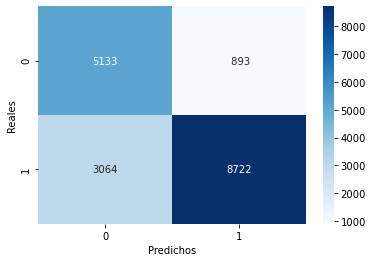

In [99]:
y_pred = random_forest_cv.predict(X_train)
medicion(y_train,y_pred)

# Probamos en test el modelo champion : xgboost lightgbm

In [100]:
X_train.shape

(17812, 54)

In [101]:
y_train.value_counts(normalize = True)

1    0.661689
0    0.338311
Name: Class, dtype: float64

In [102]:
y_test.value_counts(normalize = True)

1    0.661728
0    0.338272
Name: Class, dtype: float64

Principales metricas: 
               precision    recall  f1-score   support

           0       0.54      0.74      0.62      2968
           1       0.83      0.67      0.75      5806

    accuracy                           0.70      8774
   macro avg       0.69      0.71      0.68      8774
weighted avg       0.73      0.70      0.70      8774
 

------------------------------------------------------------------------

Area bajo la curva de roc: 0.71 

------------------------------------------------------------------------



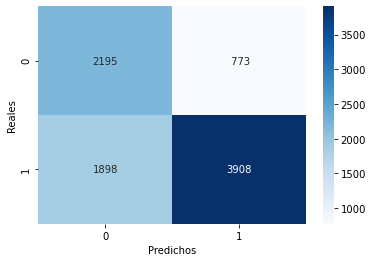

In [151]:
#Pasamos al pipeline del modelo champion 
y_pred_champion = random_forest_cv.predict(X_test)
medicion(y_test,y_pred_champion)

In [123]:
import pickle
import os

In [128]:
with open('champion_model.pkl', 'wb') as champion_model:
    pickle.dump(random_forest_cv, champion_model)

In [129]:
#Valido que se haya creado el archivo pickle
[x for x in os.listdir() if 'pkl' in x]

['champion_model.pkl']

In [130]:
with open('./champion_model.pkl', 'rb') as champion_model:
        model_open = pickle.load(champion_model)

In [131]:
#Valido que se haya cargado el modelo
model_open

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10541, shuffle=True),
                   estimator=Pipeline(steps=[('preprocesamiento',
                                              StandardScaler()),
                                             ('estimator',
                                              RandomForestClassifier())]),
                   n_iter=5,
                   param_distributions={'estimator__bootstrap': [True],
                                        'estimator__max_depth': [5, 10, 15, 20,
                                                                 25, 30, 35, 40,
                                                                 45, 50],
                                        'estimator__max_samples': [0.3, 0.4,
                                                                   0.5, 0.6,
                                                                   0.7, 0.8],
                                        'estimator__n_estimators': [10, 60, 110,
